In [18]:
import simtk.openmm as mm
import simtk.openmm.app as app
from simtk import unit
import openmmtools
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#-------------------------------------------------------------------------------
# Build a TIP3P water box using openmmtools
#-------------------------------------------------------------------------------
waterbox = openmmtools.testsystems.WaterBox(
    box_edge=26.2*unit.angstrom, 
    cutoff=12.0*unit.angstrom,
    model='tip3p',
    switch_width=2.0*unit.angstrom,
    constrained=True,
    dispersion_correction=True,
    nonbondedMethod=app.PME
)


Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [19]:
# Extract the System and Topology from the waterbox
system = waterbox.system
topology = waterbox.topology

#-------------------------------------------------------------------------------
# Add two new oxygen atoms for O2 to the System
#-------------------------------------------------------------------------------
# O2 has two O atoms, each ~16 amu
particle_index_1 = system.addParticle(15.999*unit.amu)  # will be 1728 if waterbox had 1728 waters x 3 = 5184 particles
particle_index_2 = system.addParticle(15.999*unit.amu)  # will be 1729

# Create a positions array that includes the new O2
positions_list = (waterbox.positions / unit.nanometer).tolist()
positions_list.append([-0.0508, 0.0, 0.0])  # x = -0.0508 nm
positions_list.append([ 0.0508, 0.0, 0.0])  # x = +0.0508 nm
positions = np.array(positions_list) * unit.nanometer

# Shift everything so that min x, y, z = 0.0 (just as an example)
positions[:,0] -= np.amin(positions[:,0])
positions[:,1] -= np.amin(positions[:,1])
positions[:,2] -= np.amin(positions[:,2])

# Add a constraint between the two O atoms (0.1016 nm apart)
system.addConstraint(particle_index_1, particle_index_2, 0.1016*unit.nanometer)



1728

In [20]:
#-------------------------------------------------------------------------------
# Modify the Topology to include a new chain and residue for O2
#-------------------------------------------------------------------------------
# Note: Depending on your OpenMM version, you can pass a chainId to addChain().

o2_chain = topology.addChain()   # create a new chain with default ID
o2_chain.id = 'O2'               # manually give it the ID 'O2'

o2_res = topology.addResidue('O2', o2_chain)
topology.addAtom('OA', app.Element.getBySymbol('O'), o2_res)
topology.addAtom('OB', app.Element.getBySymbol('O'), o2_res)



<Atom 1729 (OB) of chain 1 residue 576 (O2)>

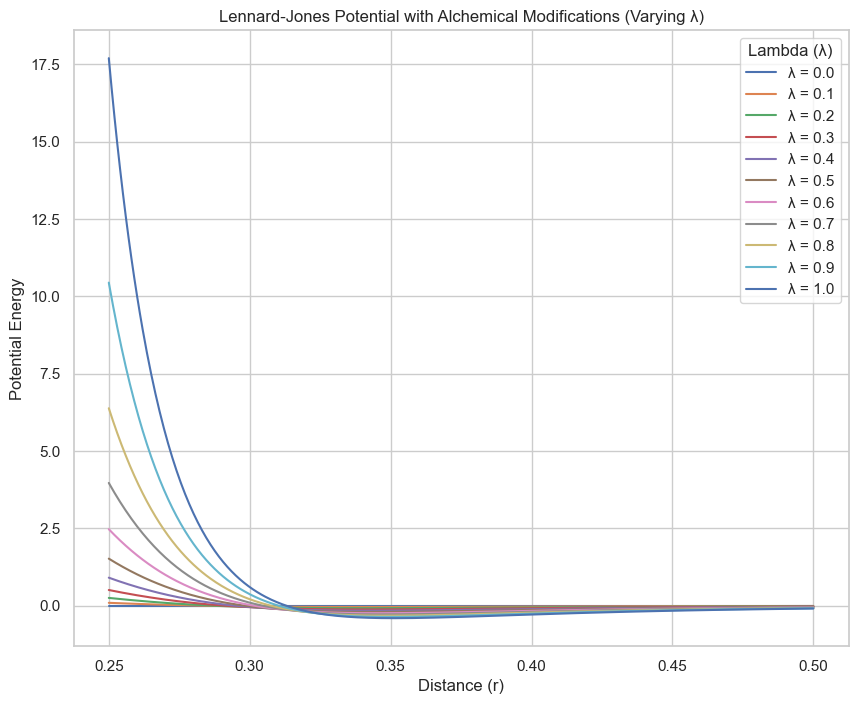

In [21]:
# This code block is for visualisation purtposes only
# Define the potential function
def calc_pot(r, eps1, eps2, sig1, sig2, lamda, useLambda1, useLambda2):
       step = 1.0 if (useLambda1 + useLambda2 - 0.5) >= 0 else 0.0
       l12 = 1 - (1 - lamda) * step
       sigma = 0.5 * (sig1 + sig2)
       epsilon = np.sqrt(eps1 * eps2)
       alphaLJ = 0.5
       potential = 4 * epsilon * l12 * (
              1 / ((alphaLJ * (1 - l12) + (r / sigma) ** 6) ** 2)
              - 1 / (alphaLJ * (1 - l12) + (r / sigma) ** 6)
       )
       return potential

# Generate data for plotting
r_values = np.linspace(0.25, 0.5, 500)  # Distance values
eps1, eps2 = 0.4029, 0.4029  # Epsilon values
sig1, sig2 = 0.313, 0.313  # Sigma values
# Vary lambda between 0.0 and 1.0
lambda_values = np.linspace(0.0, 1.0, 11)  # 11 points from 0.0 to 1.0
all_potentials = []
useLambda1, useLambda2 = 1, 1
# Calculate potentials for each lambda
for lamda in lambda_values:
       potentials = [calc_pot(r, eps1, eps2, sig1, sig2, lamda, useLambda1, useLambda2) for r in r_values]
       all_potentials.append(potentials)

# Plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Plot each lambda's potential
for i, lamda in enumerate(lambda_values):
       sns.lineplot(x=r_values, y=all_potentials[i], label=f"λ = {lamda:.1f}")

plt.xlabel("Distance (r)")
plt.ylabel("Potential Energy")
plt.title("Lennard-Jones Potential with Alchemical Modifications (Varying λ)")
plt.legend(title="Lambda (λ)")
plt.show()

In [22]:
#-------------------------------------------------------------------------------
# Create a CustomNonbondedForce for O2–water LJ interactions (alchemical)
#-------------------------------------------------------------------------------
forces = { force.__class__.__name__ : force for force in system.getForces() }
waterbox_nbforce = forces['NonbondedForce']  # the original nonbonded from the WaterBox

lambda_value = 0.0
alchemical_nbforce = mm.CustomNonbondedForce(
    """4*epsilon*l12*(1/((alphaLJ*(1-l12) + (r/sigma)^6)^2) - 1/(alphaLJ*(1-l12) + (r/sigma)^6));
       sigma=0.5*(sigma1+sigma2);
       epsilon=sqrt(epsilon1*epsilon2);
       alphaLJ=0.5;
       l12=1-(1-lambda)*step(useLambda1+useLambda2-0.5)"""
)
alchemical_nbforce.addPerParticleParameter("sigma")     # [0]
alchemical_nbforce.addPerParticleParameter("epsilon")   # [1]
alchemical_nbforce.addPerParticleParameter("useLambda") # [2]
alchemical_nbforce.addGlobalParameter("lambda", lambda_value)

alchemical_nbforce.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)
alchemical_nbforce.setCutoffDistance(12.0*unit.angstrom)
# Use a switching function for demonstration
alchemical_nbforce.setUseSwitchingFunction(True)
alchemical_nbforce.setSwitchingDistance(2.0*unit.angstrom)

# Add parameters for every particle in the System to the new CustomNonbondedForce
for p_index in range(system.getNumParticles()):
    if p_index in [particle_index_1, particle_index_2]:
        # O2 LJ parameters
        sigma = 0.313 * unit.nanometer
        epsilon = 0.4029 * unit.kilojoule / unit.mole
        alchemical_nbforce.addParticle([sigma, epsilon, 1])  
    else:
        # Water parameters from the original NonbondedForce
        charge, sig, eps = waterbox_nbforce.getParticleParameters(p_index)
        alchemical_nbforce.addParticle([sig, eps, 0])  

system.addForce(alchemical_nbforce)

3

In [23]:
#-------------------------------------------------------------------------------
# Create a new "normal" NonbondedForce for all charges and water–water LJ
#-------------------------------------------------------------------------------
nbforce = mm.NonbondedForce()
nbforce.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)
nbforce.setCutoffDistance(12.0*unit.angstrom)
nbforce.setUseSwitchingFunction(True)
nbforce.setSwitchingDistance(2.0*unit.angstrom)
nbforce.setUseDispersionCorrection(True)

# We must define parameters for all particles here too
for p_index in range(system.getNumParticles()):
    if p_index in [particle_index_1, particle_index_2]:
        # O2 does not interact here (alchemical only)
        nbforce.addParticle(0.0*unit.coulomb, 0.0*unit.nanometer, 0.0*unit.kilojoule/unit.mole)
    else:
        charge, sig, eps = waterbox_nbforce.getParticleParameters(p_index)
        nbforce.addParticle(charge, sig, eps)

system.addForce(nbforce)

#-------------------------------------------------------------------------------
# Now remove the original NonbondedForce from the WaterBox
#-------------------------------------------------------------------------------

# Note here I use index to identify the force to remove
system.removeForce(1)

In [24]:
#-------------------------------------------------------------------------------
# Build the integrator and barostat
#-------------------------------------------------------------------------------
integrator = mm.LangevinIntegrator(
    310*unit.kelvin, 
    1.0/unit.picosecond, 
    2.0*unit.femtosecond
)
barostat = mm.MonteCarloBarostat(1.0*unit.bar, 310*unit.kelvin, 25)
system.addForce(barostat)

#-------------------------------------------------------------------------------
# Create the Simulation and set positions & box vectors
#-------------------------------------------------------------------------------
simulation = app.Simulation(topology, system, integrator)

# In many cases, you get the default box from the system:
box_vectors = system.getDefaultPeriodicBoxVectors()
simulation.context.setPeriodicBoxVectors(*box_vectors)
simulation.context.setPositions(positions)

print("Simulation successfully created!")

Simulation successfully created!


In [25]:
# ---------------------------------------------------------------------
# 1) Energy Minimization at lambda=0
# ---------------------------------------------------------------------
print('Minimizing with lambda=0')
simulation.minimizeEnergy()

# Get minimized positions and write them to a PDB file
min_positions = simulation.context.getState(getPositions=True).getPositions()
with open('O2_alchemical_insertion_min.pdb', 'w') as pdb_file:
    app.PDBFile.writeFile(topology, min_positions, pdb_file)

# ---------------------------------------------------------------------
# 2) Set up MD reporters
# ---------------------------------------------------------------------
# Define how many steps in total we will run, and how frequently to write outputs
mdsteps   = 500 * 11   # 1 ps per lambda increment at 2 fs timestep => 500 steps/ps
dcdperiod = 500        # Write DCD frames every 1 ps
logperiod = 50         # Write log info every 0.1 ps

print('Setting reporters')

# 2.a) Print simulation info to terminal (stdout)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        logperiod,
        step=True, time=True, 
        potentialEnergy=True, kineticEnergy=True, totalEnergy=True,
        temperature=True, volume=True, density=True, speed=True,
        progress=True, remainingTime=True,
        totalSteps=mdsteps,
        separator='\t'
    )
)

# 2.b) Write the same info to a log file
simulation.reporters.append(
    app.StateDataReporter(
        'O2_alchemical_insertion.log',
        logperiod,
        step=True, time=True, 
        potentialEnergy=True, kineticEnergy=True, totalEnergy=True,
        temperature=True, volume=True, density=True, speed=True,
        progress=True, remainingTime=True,
        totalSteps=mdsteps,
        separator='\t'
    )
)

# 2.c) Write trajectory frames to DCD
simulation.reporters.append(
    app.DCDReporter('O2_alchemical_insertion.dcd', dcdperiod)
)

# ---------------------------------------------------------------------
# 3) Alchemical Insertion: ramping up lambda over 10 ps
# ---------------------------------------------------------------------
# At the end of each 1 ps (500 steps), we increase lambda by 0.1.
# We'll repeat this 10 times, then do a final 1 ps at lambda=1.0.

for i in range(10):
    current_lambda = simulation.context.getParameter('lambda')
    print(f'Simulating for 1 ps at lambda={current_lambda:.2f}')
    
    # Run 1 ps of MD (500 steps at 2 fs/step)
    simulation.step(500)
    
    # Increase lambda by 0.1
    new_lambda = current_lambda + 0.1
    simulation.context.setParameter('lambda', new_lambda)

# Do one final 1 ps block at lambda=1.0
final_lambda = simulation.context.getParameter('lambda')
print(f'Simulating for 1 ps at lambda={final_lambda:.2f}')
simulation.step(500)

# ---------------------------------------------------------------------
# 4) Save final structures and serialized states
# ---------------------------------------------------------------------
last_positions = simulation.context.getState(getPositions=True).getPositions()
with open('O2_alchemical_insertion_last.pdb', 'w') as pdb_file:
    app.PDBFile.writeFile(topology, last_positions, pdb_file)

# Create a State object holding final positions, velocities, etc.
state = simulation.context.getState(
    getPositions=True,
    getVelocities=True,
    getForces=True,
    getEnergy=True,
    getParameters=True,
    enforcePeriodicBox=True
)

# 4.a) Write system.xml (force field parameters)
with open('O2_system.xml', 'w') as sys_xml:
    system_xml = mm.XmlSerializer.serialize(simulation.system)
    sys_xml.write(system_xml)

# 4.b) Write integrator.xml (integrator configuration)
with open('O2_integrator.xml', 'w') as int_xml:
    integrator_xml = mm.XmlSerializer.serialize(simulation.integrator)
    int_xml.write(integrator_xml)

# 4.c) Write state.xml (positions, velocities, etc.)
with open('O2_state.xml', 'w') as st_xml:
    state_xml = mm.XmlSerializer.serialize(state)
    st_xml.write(state_xml)

# 4.d) Also save a binary checkpoint for fast restarts on the same system
simulation.saveCheckpoint('O2_state.chk')

print('Alchemical insertion complete. Data saved to PDB, DCD, log, and XML files.')

Minimizing with lambda=0
Setting reporters
Simulating for 1 ps at lambda=0.00
#"Progress (%)"	"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Kinetic Energy (kJ/mole)"	"Total Energy (kJ/mole)"	"Temperature (K)"	"Box Volume (nm^3)"	"Density (g/mL)"	"Speed (ns/day)"	"Time Remaining"
0.9%	50	0.10000000000000007	-463236.19030449056	469.4524849669833	-462766.73781952355	32.627654404876644	17.944891643069777	0.9631855279654584	0	--
1.8%	100	0.20000000000000015	-462885.7239455166	869.1243688864633	-462016.59957663016	60.405451991330786	17.9500251830398	0.9629100658780275	236	0:03
2.7%	150	0.3000000000000002	-462556.8805273861	1199.006679048296	-461357.8738483378	83.33276914250018	18.102667756364514	0.9547907614575938	301	0:03
3.6%	200	0.4000000000000003	-462297.0938373643	1531.8665907253744	-460765.2272466389	106.46703408137103	17.974649006824393	0.9615909565160817	335	0:02
4.5%	250	0.5000000000000003	-462033.9194149417	1844.3522827583365	-460189.56713218335	128.18526008423748	18.00721426609